<a href="https://colab.research.google.com/github/lprockop/NLPGroup10/blob/main/PrelimAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Final Project

## Last updated:
03/28/23, Lyle

### Current state:
  
Data is imported and eFMD scores are run.  
eFMD already includes necessary preprocessing steps (removing special characters and lowercasing letters) so those steps are kept in at the end in case we want to use them for other scorers/analyses.

### Next steps:
1. Decide which scores to look at (comes back to hypotheses; do we also want SimpleSenti?)
2. Isolate NYT and SCOTUS scores, look at trends over time (for hypotheses 1 and 2)

### Import data

In [ ]:
#read in csvs (note: I've downloaded these from the Data Google folder and re-uploaded in this runtime)
import pandas as pd
nyt = pd.read_csv('first_1200_articles (3).csv').drop(columns='Unnamed: 0')
sc = pd.read_csv('Abortion_final (Cases).csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

#add year column to NYT dataset
year = []
for i in nyt.pub_date:
  year.append(int(i[0:4]))
nyt['year'] = year

### Sentiment analysis using eFMD

In [ ]:
#install necessary modules
!pip install -U pip setuptools wheel
!pip install -U spacy==3.4.0
!python -m spacy download en_core_web_sm
!pip install git+https://github.com/medianeuroscience/emfdscore.git

In [ ]:
#import packages we'll need
import pandas as pd 
import numpy as np

In [ ]:
#format text columns in the proper format for eFMD...
#...in NYT dataframe
template_input_nyt = pd.DataFrame(nyt['abstract']).sort_values('abstract', ascending=False).dropna()
template_input_nyt = template_input_nyt[template_input_nyt['abstract']!=''].sort_values('abstract').rename({'abstract':0}, axis=1)
template_input_nyt = template_input_nyt.reset_index().drop('index', axis=1)
#...in SC dataframe
template_input_sc = pd.DataFrame(sc['text']).sort_values('text', ascending=False).dropna()
template_input_sc = template_input_sc[template_input_sc['text']!=''].sort_values('text').rename({'text':0}, axis=1)
template_input_sc = template_input_sc.reset_index().drop('index', axis=1)

In [ ]:
#import and run eFMD scoring
from emfdscore.scoring import score_docs 
num_docs_nyt = len(template_input_nyt)
num_docs_sc = len(template_input_sc)
DICT_TYPE = 'emfd'
PROB_MAP = 'all'
SCORE_METHOD = 'bow'
OUT_METRICS = 'sentiment'
#create new dfs to hold the results
df_nyt = score_docs(template_input_nyt, DICT_TYPE, PROB_MAP, SCORE_METHOD, OUT_METRICS, num_docs_nyt)
df_sc = score_docs(template_input_sc, DICT_TYPE, PROB_MAP, SCORE_METHOD, OUT_METRICS, num_docs_sc)
#combine dfs that hold the initial data with the results
nyt_df = pd.concat((nyt, df_nyt), axis=1)
sc_df = pd.concat((sc, df_sc), axis=1)
#examine output for SC
sc_df.head()

Processed: 1189 100% |❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤| Elapsed Time: 0:00:09 Time:  0:00:09
Processed: 34 100% |❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤| Elapsed Time: 0:00:12 Time:  0:00:12


,author_name,category,per_curiam,case_name,date_filed,federal_cite_one,absolute_url,cluster,year_filed,scdb_id,...,authority_p,sanctity_p,care_sent,fairness_sent,loyalty_sent,authority_sent,sanctity_sent,moral_nonmoral_ratio,f_var,sent_var
0,Justice Blackmun,majority,False,Roe v. Wade,1973-01-22,NaN,https://www.courtlistener.com/opinion/108713/r...,https://www.courtlistener.com/api/rest/v3/clus...,1973,1972-048,...,0.104372,0.092741,-0.071447,-0.045651,-0.026034,-0.034011,-0.047386,1.399520,0.000089,0.000296
1,Justice O'Connor and Kennedy and Souter,majority,False,Planned Parenthood of Southeastern Pa. v. Casey,1992-06-29,NaN,https://www.courtlistener.com/opinion/112786/p...,NaN,1992,1991-117,...,0.104660,0.086185,-0.089379,-0.015917,-0.007430,-0.005189,-0.051946,1.174528,0.000169,0.001313
2,Justice Stewart,concurring,False,Roe v. Wade,1973-01-22,NaN,https://www.courtlistener.com/opinion/108713/r...,https://www.courtlistener.com/api/rest/v3/clus...,1973,1972-048,...,0.104747,0.082228,-0.089115,-0.024546,-0.029659,-0.038441,-0.071355,1.054968,0.000187,0.000795
3,Justice Rehnquist,dissenting,False,Roe v. Wade,1973-01-22,NaN,https://www.courtlistener.com/opinion/108713/r...,https://www.courtlistener.com/api/rest/v3/clus...,1973,1972-048,...,0.105832,0.086574,-0.080738,-0.044666,-0.030372,-0.028697,-0.051229,1.013566,0.000106,0.000443
4,per_curiam,per_curiam,True,Poelker v. Doe,1977-06-20,NaN,https://www.courtlistener.com/opinion/109712/p...,https://www.courtlistener.com/api/rest/v3/clus...,1977,1976-157,...,0.111808,0.089833,-0.060753,-0.017840,0.010005,-0.010293,-0.019440,1.356859,0.000158,0.000665


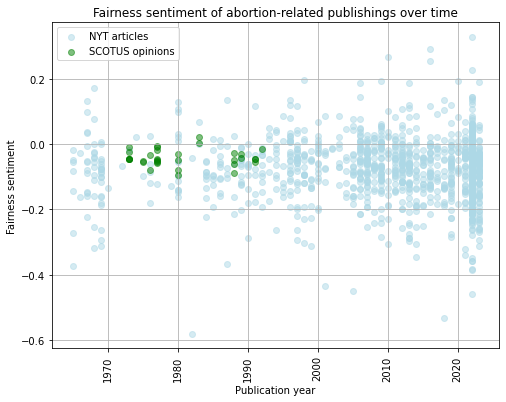

In [ ]:
#visualize some scores over time
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(nyt_df.year, nyt_df.fairness_sent, alpha=0.5, color='lightblue', label='NYT articles')
plt.scatter(sc_df.year_filed, sc_df.fairness_sent, alpha=0.5, color='green', label='SCOTUS opinions')
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Publication year')
plt.ylabel('Fairness sentiment')
plt.title('Fairness sentiment of abortion-related publishings over time')
plt.grid()
plt.show()

#### Note: scores that are calculated:


```
'care_p', 'fairness_p', 'loyalty_p', 'authority_p', 'sanctity_p', 
'care_sent', 'fairness_sent', 'loyalty_sent', 'authority_sent',
'sanctity_sent', 'moral_nonmoral_ratio', 'f_var', 'sent_var'
```

### Archive: Data cleaning (not necessary for eFMD)

In [ ]:
def clean_text(str_in):
    import re
    tmp = re.sub(r'[^\w]', " ",str_in).lower().strip().replace("  ", " ")
    return tmp

#### Clean NYT abstract

In [ ]:
abs_clean = []
for i in nyt.abstract:
  try:
    abs_clean.append(clean_text(i))
  except:
    abs_clean.append('')

nyt['abstract_clean'] = abs_clean
nyt = nyt[['pub_date', 'abstract_clean']]
nyt.head()

,pub_date,abstract_clean
0,2023-03-17T19:54:54+0000,cases in poland and texas bring legal vulnerab...
1,2023-03-18T02:30:36+0000,the law is the only one in the nation to prohi...
2,2023-03-08T11:46:02+0000,since roe v wade ended the battle over legal a...
3,2023-03-13T22:23:59+0000,six works in a lewis clark exhibition about he...
4,2023-03-14T19:44:31+0000,it was the first conviction of its type in the...


#### Clean Supreme Court decisions

In [ ]:
text_clean = []
for i in sc.text:
  try:
    text_clean.append(clean_text(i))
  except:
    text_clean.append('')

sc['text_clean'] = text_clean
sc = sc[['year_filed', 'text_clean']]
sc.head()

,year_filed,text_clean
0,1973,this texas federal appeal and its georgia comp...
1,1992,i liberty finds no refuge in a jurisprudence o...
2,1973,in 1963 this court in ferguson v skrupa 372 u ...
3,1973,the court s opinion brings to the decision of ...
4,1977,respondent jane doe an indigent sought unsucce...
